# AI Trading Strategy - Exam Project


Project for the course "AI and Finance" 2023/2024.

Team Composition: 
- Davide Bergamasco
- Virginia Filippi
- Martina Toffoli


**Objective of the project**

The objective of the presented project is to implement a deep reinforcement learning technique for intraday trading on the IVV's dataset of daily market movements. 
The primary goal of this project is to design and implement a robust algorithm capable of learning optimal trading strategies in a dynamic and complex market environment. 

The technique developed in the following project is the **DQN (Deep Q-Network) algorithm** augmented with a **Long Short Term Memory (LSTM)** neural network. We have used a neural network architecture that integrates DQN with a LSTM layer well-suited to extract deeper temporal patterns in the input data.

## Data import and analysis

Load the libraries

In [1]:
import time
import numpy as np
import torch
from empyrical import max_drawdown, sharpe_ratio, cagr, annual_volatility, value_at_risk, conditional_value_at_risk
from lib.DQNAgent import DQNAgent
from lib.IVVEnvironment import IVVEnvironment

from lib.utils import *

Disable warning and set the device

In [2]:
device = "cpu" if not torch.cuda.is_available() else 'cuda'

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

### Data import

In [3]:
train_path = "lib/data/IVV_1m_training.csv"
validation_path = "lib/data/IVV_1m_validation.csv"

### Exploratory data analysis

Training data

Train data observations:  (978037, 5)
Columns:  ['Low' 'Volume' 'Open' 'High' 'Close']
---------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 978037 entries, 2007-01-03 14:30:00+00:00 to 2016-12-30 20:59:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Low     978037 non-null  float64
 1   Volume  978037 non-null  int64  
 2   Open    978037 non-null  float64
 3   High    978037 non-null  float64
 4   Close   978037 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 44.8 MB
---------------
Correlation matrix


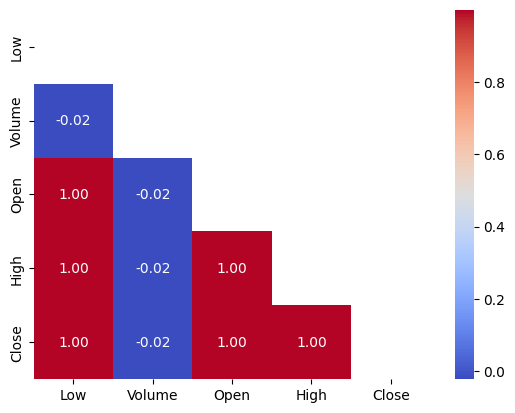

---------------
Dataset visualization


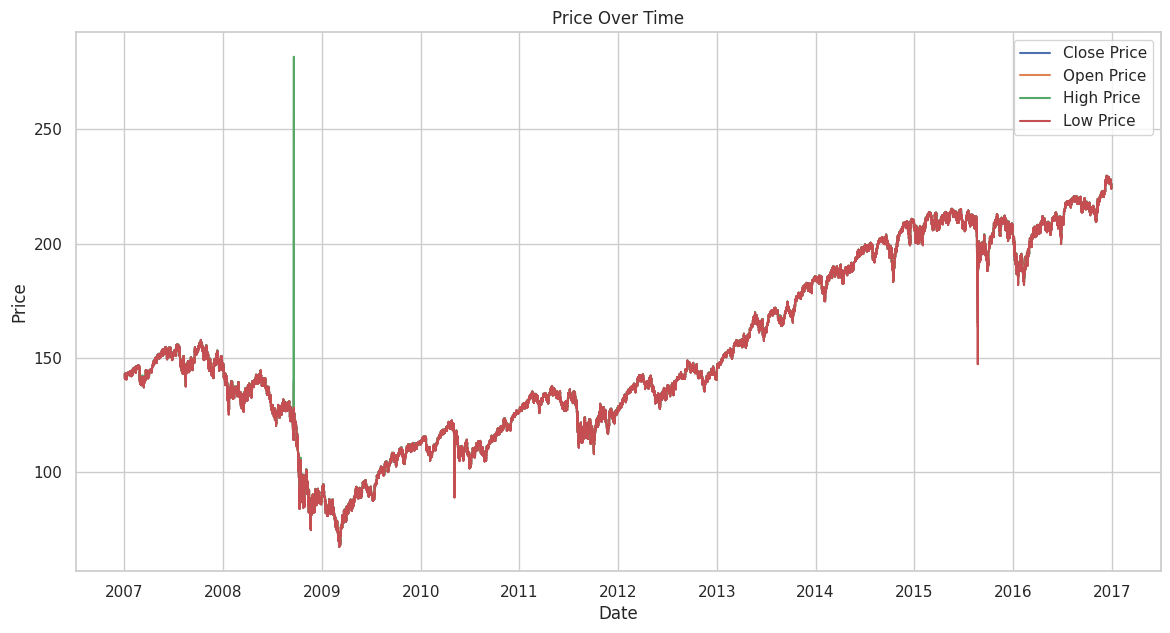

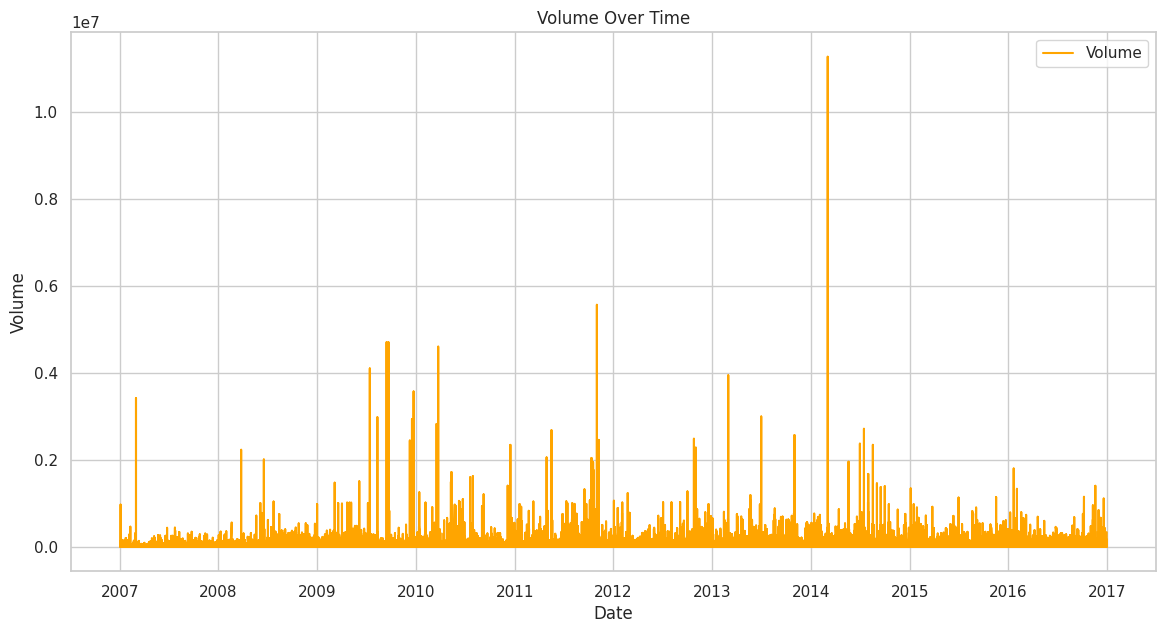

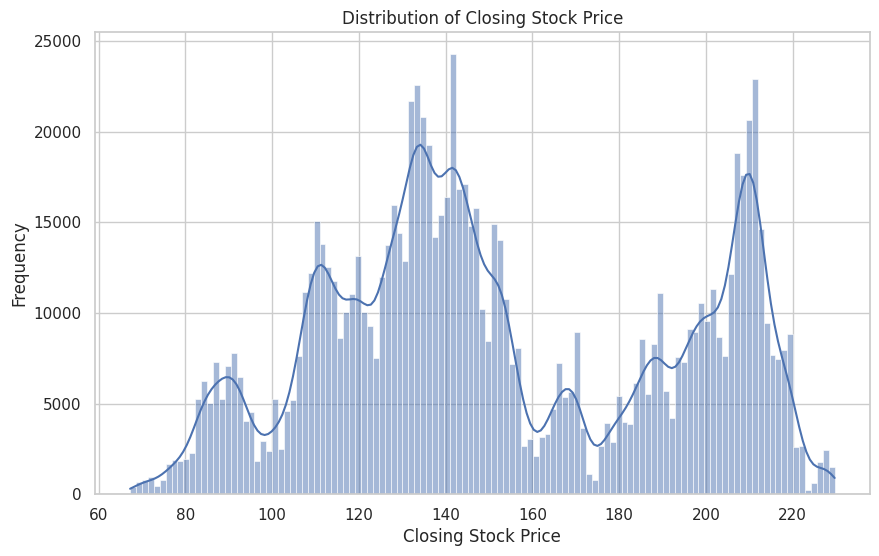

In [4]:
train_data_eda = data_info(train_path)
train_data_eda = data_visualization(train_data_eda)

Stationarity analysis: Augmented Dickey-Fuller test (ADF):
ADF Statistic: -2.432637
p-value: 0.132736
Critical Values:
1%: -3.4304154038354513
5%: -2.8615689074705455
10%: -2.5667853864350403
The ADF test could not affirm whether or not the time series is stationary...


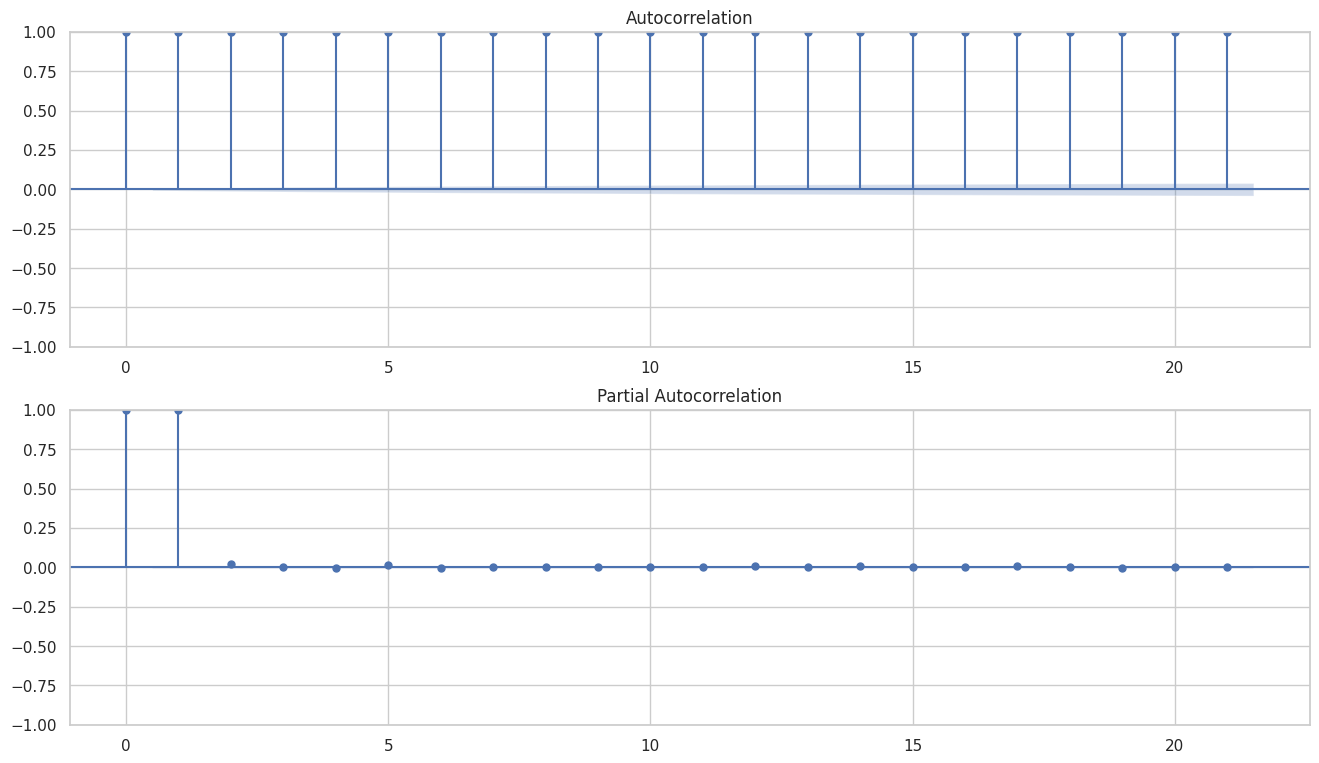

In [5]:
check_stationarity(train_data_eda['Close'][:100000])
autocorrelation(train_data_eda['Close'][:100000])

Outliers
Empty DataFrame
Columns: [Low, Volume, Open, High, Close, Date]
Index: []


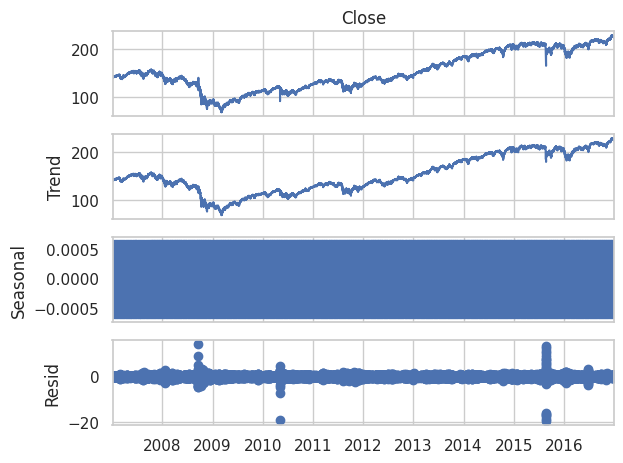

In [7]:
statistic_analysis(train_data_eda)

Validation data

Train data observations:  (292620, 5)
Columns:  ['Low' 'Volume' 'Open' 'High' 'Close']
---------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292620 entries, 2017-01-03 14:30:00+00:00 to 2019-12-31 20:59:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Low     292620 non-null  float64
 1   Volume  292620 non-null  int64  
 2   Open    292620 non-null  float64
 3   High    292620 non-null  float64
 4   Close   292620 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 13.4 MB
---------------
Correlation matrix


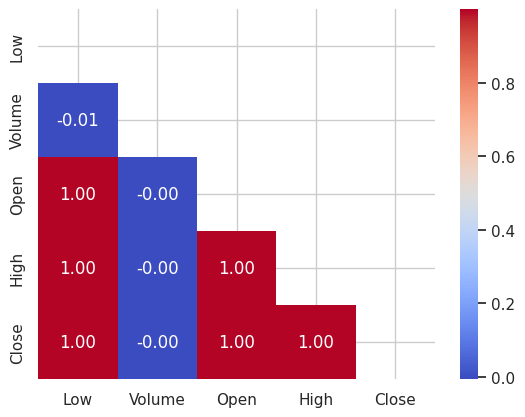

---------------
Dataset visualization


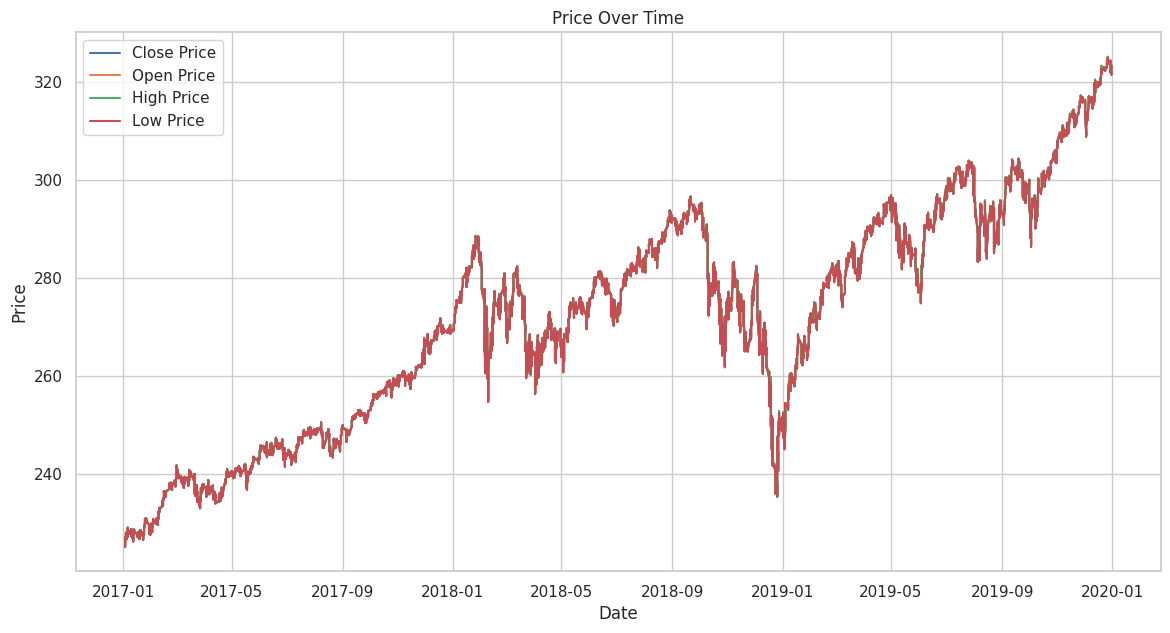

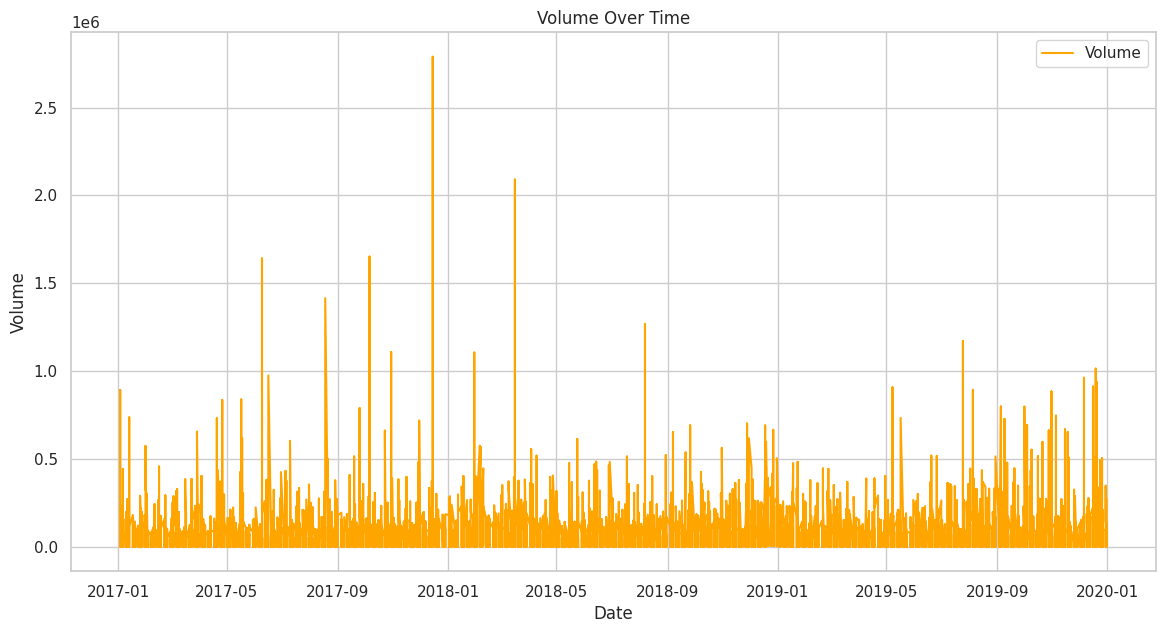

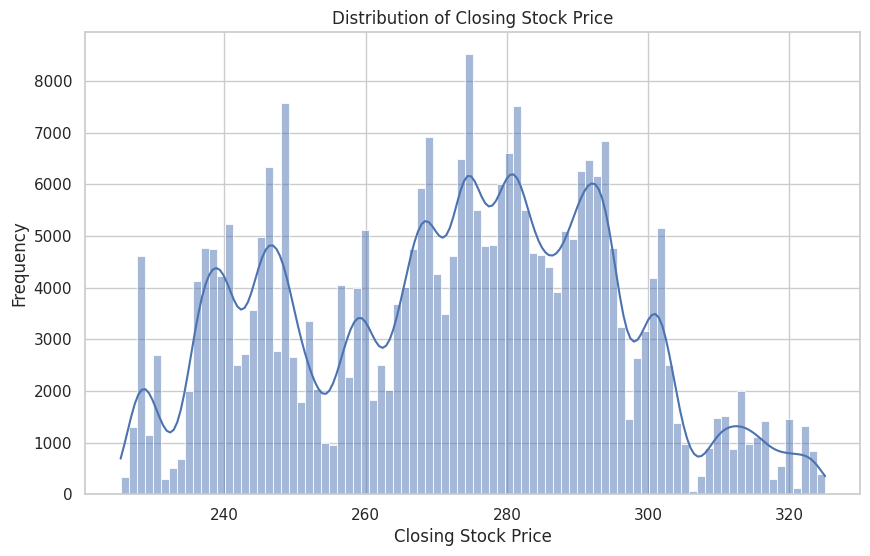

In [8]:
val_data_eda = data_info(validation_path)
val_data_eda = data_visualization(val_data_eda)

Stationarity analysis: Augmented Dickey-Fuller test (ADF):
ADF Statistic: 0.331833
p-value: 0.978759
Critical Values:
1%: -3.4304154123404644
5%: -2.8615689112295866
10%: -2.5667853884358536
The ADF test could not affirm whether or not the time series is stationary...


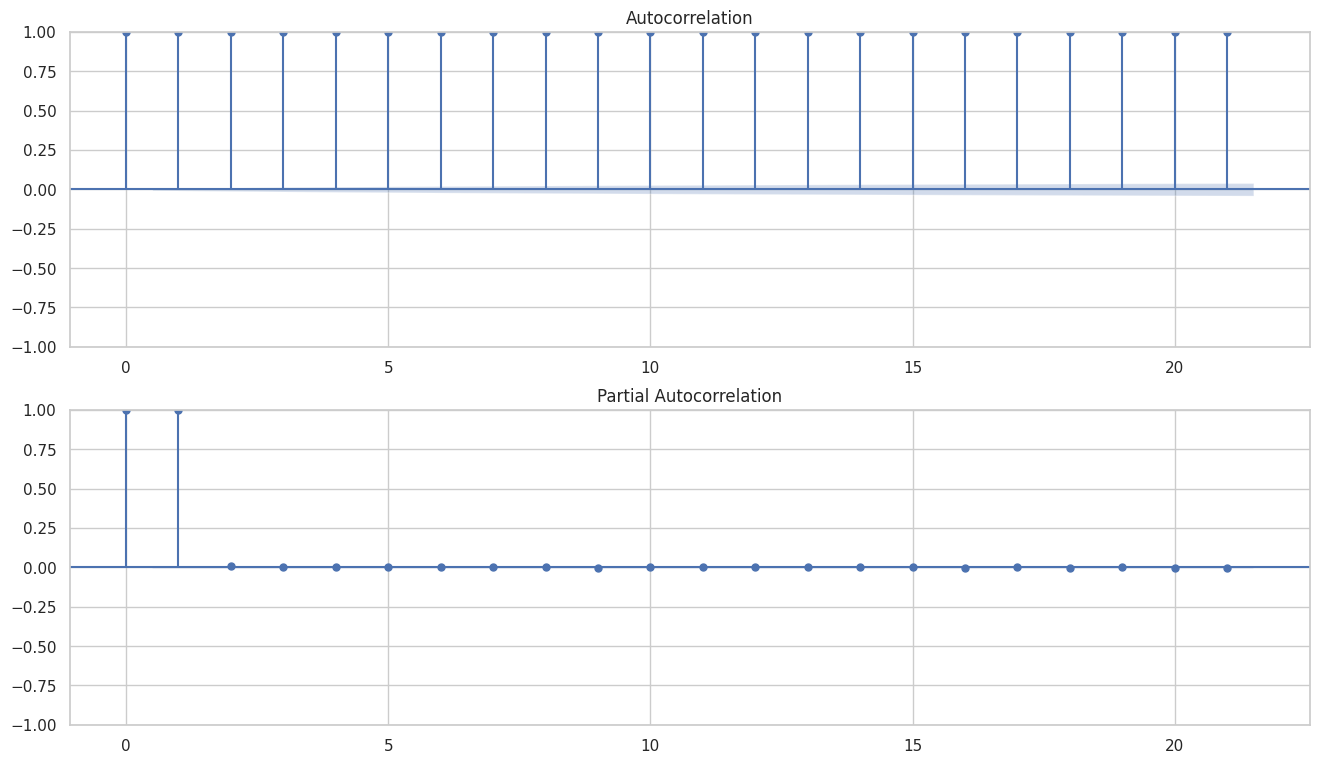

In [9]:
check_stationarity(val_data_eda['Close'][:100000])
autocorrelation(val_data_eda['Close'][:100000])

Outliers
Empty DataFrame
Columns: [Low, Volume, Open, High, Close, Date]
Index: []


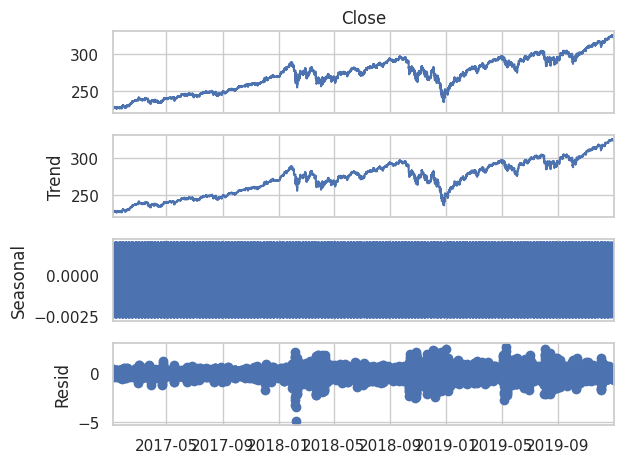

In [11]:
statistic_analysis(val_data_eda)

## Method and assumptions

**Agent description**

- The core of the agent is based on an **LSTM** (Long Short Term Memory) network, which is well-suited for extracting temporal patterns in the input data.

- The state of the agent is composed by:
    - the close price in difference w.r.t the previous minute
    - a variable that tells if the price is increasing or not from the beginning of the window size
    - the last action type that opened a new position 
    - the number of actions performed until the current minute

- The agent employs an *epsilon-greedy* policy for action selection, doing more exploration at the beginning of the training: it performs random actions between actions performed by the model (exploitation).

- The loss between the predicted Q-values and the target Q-values is calculated using Mean Squared Error (MSE) loss.


**Environment**

The environnment creates a trading setup where the agent can learn.
An agent can only have one position opened at a time. Consequent BUY or SELL actions are treated as a single BUY/SELL action.

*Episodes*

A single episode represents a day of trading in the data. A single step is a minute.

*Actions*
- [0] **HOLD**: do nothing
- [1] **BUY**: BUY one unit of the asset
- [2] **SELL**: SELL one unit of the asset


**Reward Function**

The reward function is designed to evaluate the performance of the trading strategy. 

The reward takes into account different properties:
- if the agent closes a position with some profit, the reward is that profit ( SELL + BUY or BUY + SELL)
- the total number of trades done at the end of the episode, penalizing when the number of trades is out of the range [2, 8]
- the reward is 0 otherwise.


**Metrics**

Several financial metrics are calculated, including:
- Net return
- Profit/loss
- Success Rate
- Sharpe ratio
- Value at Risk (VaR)
- Conditional Value at Risk (CVaR)
- Maximum Drawdown
- Compounded Annual Return
- Annual Volatility

The agent's actions and the resulting financial metrics are tracked and printed at regular intervals to monitor progress of the training and the validation.

## Training and Validation

We have integrated the training and the validation, performing a validation step after each 50 episodes (1 valid year) and then after all the training steps (all valid data).

In [ ]:
window_size = 32
batch_size = 64
feature_size = 5
seed = 9
times_update_dqn = 3
TAU = 0.005

seed_everything(9)

train_environment = IVVEnvironment(train_path, seed=seed, device=device, window_size=window_size, trading_cost=1e-3)
train_environment.close()
validation_environment = IVVEnvironment(validation_path, seed=seed, device=device, window_size=window_size, trading_cost=1e-3)
agent = DQNAgent(feature_size, window_size)


In [ ]:
def perform_validation(current_episode, max_episodes=-1):
    validation_environment.close()
    
    total_net_profit = []
    total_profit_loss = []
    annual_net_profit = []
    annual_profit_loss = []
    episode_count = 0
    actions_by_model = 0
    buy_actions = 0
    sell_actions = 0
    actual_trades = []
    
    print(f'Start validation: model from ep {current_episode} on {max_episodes} days')
    agent.evaluation_mode(True)  # Ensure the agent is in evaluation mode
    while(validation_environment.there_is_another_episode() and (max_episodes == -1 or episode_count < max_episodes)):

        # Reset the environment and obtain the initial observation
        observation = validation_environment.reset()
        agent.reset_invetory()
        info = {}

        while True:

            action, action_by_model, action_buy_by_model, action_sell_by_model = agent.act(observation)
            actions_by_model += action_by_model
            buy_actions += action_buy_by_model
            sell_actions += action_sell_by_model
            next_observation, reward, done, info = validation_environment.step(action)
            
            if info['net_profit'] != 0:
                total_net_profit.append(info['net_profit'])
                annual_net_profit.append(info['net_profit'])
            if info['profit_loss'] != 0:
                total_profit_loss.append(info['profit_loss'])
                annual_profit_loss.append(info['profit_loss'])

            if done: break

            observation = next_observation

        episode_count += 1
        actual_trades.append(info["actual_trades"])
        if episode_count % 250 == 0:

            net_profit = np.array(annual_net_profit)
            profit_loss = np.array(annual_profit_loss)

            print("\n Happy new year :)")
 
            successRate = info["positive_trades"]/(info["actual_trades"]/2) if info["actual_trades"] != 0  else 0
            print('Success Rate: ', successRate)

            if len(net_profit) == 0:
                netReturn = 0
            else:
                netReturn = sum(net_profit)/len(net_profit)
            print('Net Return: ', netReturn)

            print(f"Net profit: {np.sum(net_profit)}")
            print(f"Profit: {np.sum(profit_loss)}")
            #Calculate Sharpe Ratio metric
            if(len(profit_loss) > 0):
                sharpeRatio = sharpe_ratio(profit_loss, risk_free=0)
                print('Sharpe Ratio: ', sharpeRatio)

                valueAtRisk = value_at_risk(profit_loss)
                print('Value at Risk: ', valueAtRisk)

                condValueAtRisk = conditional_value_at_risk(profit_loss)
                print('Conditional Value at Risk: ', condValueAtRisk)

            maxDrawdown = max_drawdown(profit_loss)
            print('Maximum Drawdown: ', maxDrawdown)

            annualReturn = cagr(profit_loss, annualization=1)
            print('Compounded Annual Return: ', annualReturn)

            annualVolatility = annual_volatility(profit_loss, annualization=1)
            print('Annual Volatility: ', annualVolatility)

            annual_net_profit = []
            annual_profit_loss = []
            
    print(f"{np.mean(actual_trades)} trades/day")
    print(f'Buys by model {str(buy_actions)}/{str(actions_by_model)} Sells by model {str(sell_actions)}/{str(actions_by_model)}')
    print(f'>>> Validation finished! <<< \n')

    # Save model 
    print(f'>>> Saving model... <<< \n')
    agent.save_policy(np.sum(profit_loss), np.mean(actual_trades))

    if max_episodes == len(validation_environment.dataset.days):
        plot_validation(total_profit_loss, total_net_profit, actual_trades)

    agent.evaluation_mode(False)  # Reset to training mode if needed

In [ ]:
episode_count = 0
rewards_list = []
rewards_mean_list = []

while(train_environment.there_is_another_episode()):
    # Reset the environment and obtain the initial observation
    observation = train_environment.reset()
    
    info = {}
    net_profit = []
    profit_loss = []


    episode_loss = []
    start_time = time.time()
    agent.reset_invetory()
    
    actions_by_model = 0
    buy_actions = 0
    sell_actions = 0

    while True:

        action, action_by_model, action_buy_by_model, action_sell_by_model = agent.act(observation)
        actions_by_model += action_by_model
        buy_actions += action_buy_by_model
        sell_actions += action_sell_by_model
        next_observation, reward, done, info = train_environment.step(action)
       
        if info["net_profit"] != 0:
            net_profit.append(info["net_profit"])
        if info["profit_loss"] != 0:
            profit_loss.append(info["profit_loss"])

        agent.memory.append((observation, action, reward, next_observation, done))
        rewards_list.append(reward)

        if done: break

        if len(agent.memory) > batch_size:
            loss = agent.learn_to_trade(batch_size, times_update_dqn)
            episode_loss.append(loss)

        observation = next_observation
        agent.decay()

    if episode_count % 10:
        target_net_state_dict = agent.model.state_dict()
        policy_net_state_dict = agent.target_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        agent.target_model.load_state_dict(target_net_state_dict)

    episode_count += 1

    if episode_count % 50 == 0:
        agent.evaluation_mode()
        perform_validation(episode_count, 251)
        agent.evaluation_mode(False)

    net_profit = np.array(net_profit)
    profit_loss = np.array(profit_loss)

    reward_mean = np.mean(rewards_list)
    rewards_mean_list.append(reward_mean)

    print(f">>> EPISODE: {episode_count} <<<")
    print(f"Reward: {np.mean(rewards_list):3.5f}, Profits: {sum(profit_loss)}, BUY: {len(info['when_bought'])}, SELL: {len(info['when_sold'])}, LOSS: {np.mean(episode_loss)}") #, Time: {time.time()-start_time}")
    
    print("---- Metrics ----")

    #Calculate Success Rate metric
    print(f'Buys by model {str(buy_actions)}/{str(actions_by_model)} Sells by model {str(sell_actions)}/{str(actions_by_model)}')
    print(f"Actual trades : { info['actual_trades']}")
    successRate = info["positive_trades"]/(len(info["actual_trades"])/2) if len(info["actual_trades"]) != 0  else 0
    print('Success Rate: ', successRate)
    

    #Calculate Net Return metric
    if len(net_profit) == 0:
        netReturn = 0
    else:
        netReturn = sum(net_profit)/len(net_profit)
    print('Net Return: ', netReturn)


## Results

In [ ]:
# PLOT REWARD
plot_reward(rewards_mean_list)

# VALIDATION
agent.evaluation_mode()
perform_validation(episode_count, len(validation_environment.dataset.days))
agent.evaluation_mode(False)

## Conclusion and final remarks

### Training

<img src="reward.png" alt="drawing" width="400"/>

The training reward plot shows an expected behaviour, due to the fact that at the beginning the model has a lot to learn, and then around the 500-th episode it has seen a lot of variability in the data that leads to a drop in the reward.

Going on with the training, the agent learns better to overcome these problems and the reward exceeds the previous peek.

### Validation

<img src="valid_metrics.png" alt="drawing" width="400"/>

From these results we can notice that the model doesn't achieve a positive profit in all validation years, but the success rate is reasonable due to the fact that the data are unseen from the model.
The Net return metric is low because is computed on high transaction costs that maybe are more reasonable in a real environment.


<img src="profit.png" alt="drawing" width="400"/>
<img src="trades.png" alt="drawing" width="400"/>

In the first plot we have the profit and the net profit in validation environment, in the second plot we have the number of trades per day. As you can see, the mean profit without transaction costs is around zero, while considering them the net profit is always negative.

The number of trades per day remains in most of the validation episodes inside of the range [2, 8], with an annual mean of 5.35.

## Appendix: Performance test

**TO DO**